In [1]:
import seaborn as sns
from pathlib import Path
import cv2
from tqdm import tqdm
from scipy import stats
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, make_scorer
from scipy.stats import skew, kurtosis, entropy
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.preprocessing import StandardScaler,  PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.decomposition import PCA, TruncatedSVD
from xgboost import XGBClassifier
import importlib
import ml
importlib.reload(ml)
from ml import get_hog_anatomy_filename, compute_study_hog, fit_hog_pipeline_bodyparts
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore")
LOCAL_PATH = '.'


ImportError: cannot import name 'get_hog_anatomy_filename' from 'ml' (/home/rubar01/Course 1/Project/Project2025/ml/__init__.py)

In [ ]:
# для запуска в Google colab7
def in_colab():
    try:
        import google.colab  # noqa
        return True
    except ImportError:
        return False

print(in_colab())
if in_colab():
    import kagglehub

    # Download latest version
    path = kagglehub.dataset_download("cjinny/mura-v11")

    print("Path to dataset files:", path)
else:
    path=LOCAL_PATH

Using Colab cache for faster access to the 'mura-v11' dataset.
Path to dataset files: /kaggle/input/mura-v11


In [ ]:
# для запуска в Google colab
image_dir = Path(path) / "MURA-v1.1"

In [ ]:
# датасет
#image_dir = Path('MURA-v1.1')

# Из результатов EDA нам известно, что 4 изображения из датасета "unreadable". Сразу отфильтруем их.
valid_paths = []
for path in tqdm(image_dir.rglob('*.*'), desc='Фильтрация читаемых изображений', unit='img'):
    if path.suffix.lower() in {".png", ".jpg", ".jpeg"}:
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            valid_paths.append(path)

print(len(valid_paths))


Фильтрация читаемых изображений: 40013img [06:53, 96.67img/s] 

40005


#### Применим методы createCLAHE и convertScaleAbs из библиотеки cv2 ко всем изображениям, учитывая текущие их показатели яркости и контраста.
Оптимальные параметры для каждой группы изображений подобраны путем подбора и анализа результатов обработки.

In [ ]:
# определение параметров в зависимости от текущей яркости изображений
def parameters(mean, std):
    # Контраст
    if std < 30:
        alpha = 1.3
    elif std < 50:
        alpha = 1.1
    else:
        alpha = 1.0

    # Яркость
    if mean < 40:
        beta = 20
    elif mean < 70:
        beta = 10
    else:
        beta = 0

    clip_limit = 3

    return alpha, beta, clip_limit

# функция сохранения изображений
def save_processed(img, original_path, base_input_dir, base_output_dir):
    rel_path = os.path.relpath(original_path, base_input_dir)
    output_path = os.path.join(base_output_dir, rel_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, img)

# обработка и сохранение всех изображений
def process_images(df_subset, base_input_dir, base_output_dir, tile_grid_size=(10, 10)):
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc='Обработка изображений'):
        path = row['path']
        mean = row['mean']
        std = row['std']

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        alpha, beta, clip_limit = parameters(mean, std)

        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        img_clahe = clahe.apply(img)
        img_final = cv2.convertScaleAbs(img_clahe, alpha=alpha, beta=beta)

        save_processed(img_final, path, base_input_dir, base_output_dir)


In [ ]:
#сбор датафрейма из EDA

def get_brightness_stats(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    # Переводим RGB в grayscale
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    stats = {
        'min': int(img.min()),
        'max': int(img.max()),
        'mean': float(img.mean()),
        'std': float(img.std()),
        'range': int(img.max() - img.min())
    }
    return stats

brightness_data = []

for path in tqdm(valid_paths, desc='Извлечение статистики яркости'):
    stats = get_brightness_stats(path)
    if stats:
        brightness_data.append({**stats, 'path': path})

brightness_df = pd.DataFrame(brightness_data)



Извлечение статистики яркости: 100%|██████████| 40005/40005 [04:28<00:00, 148.72it/s]


Посмотрим результат на нескольких примерах

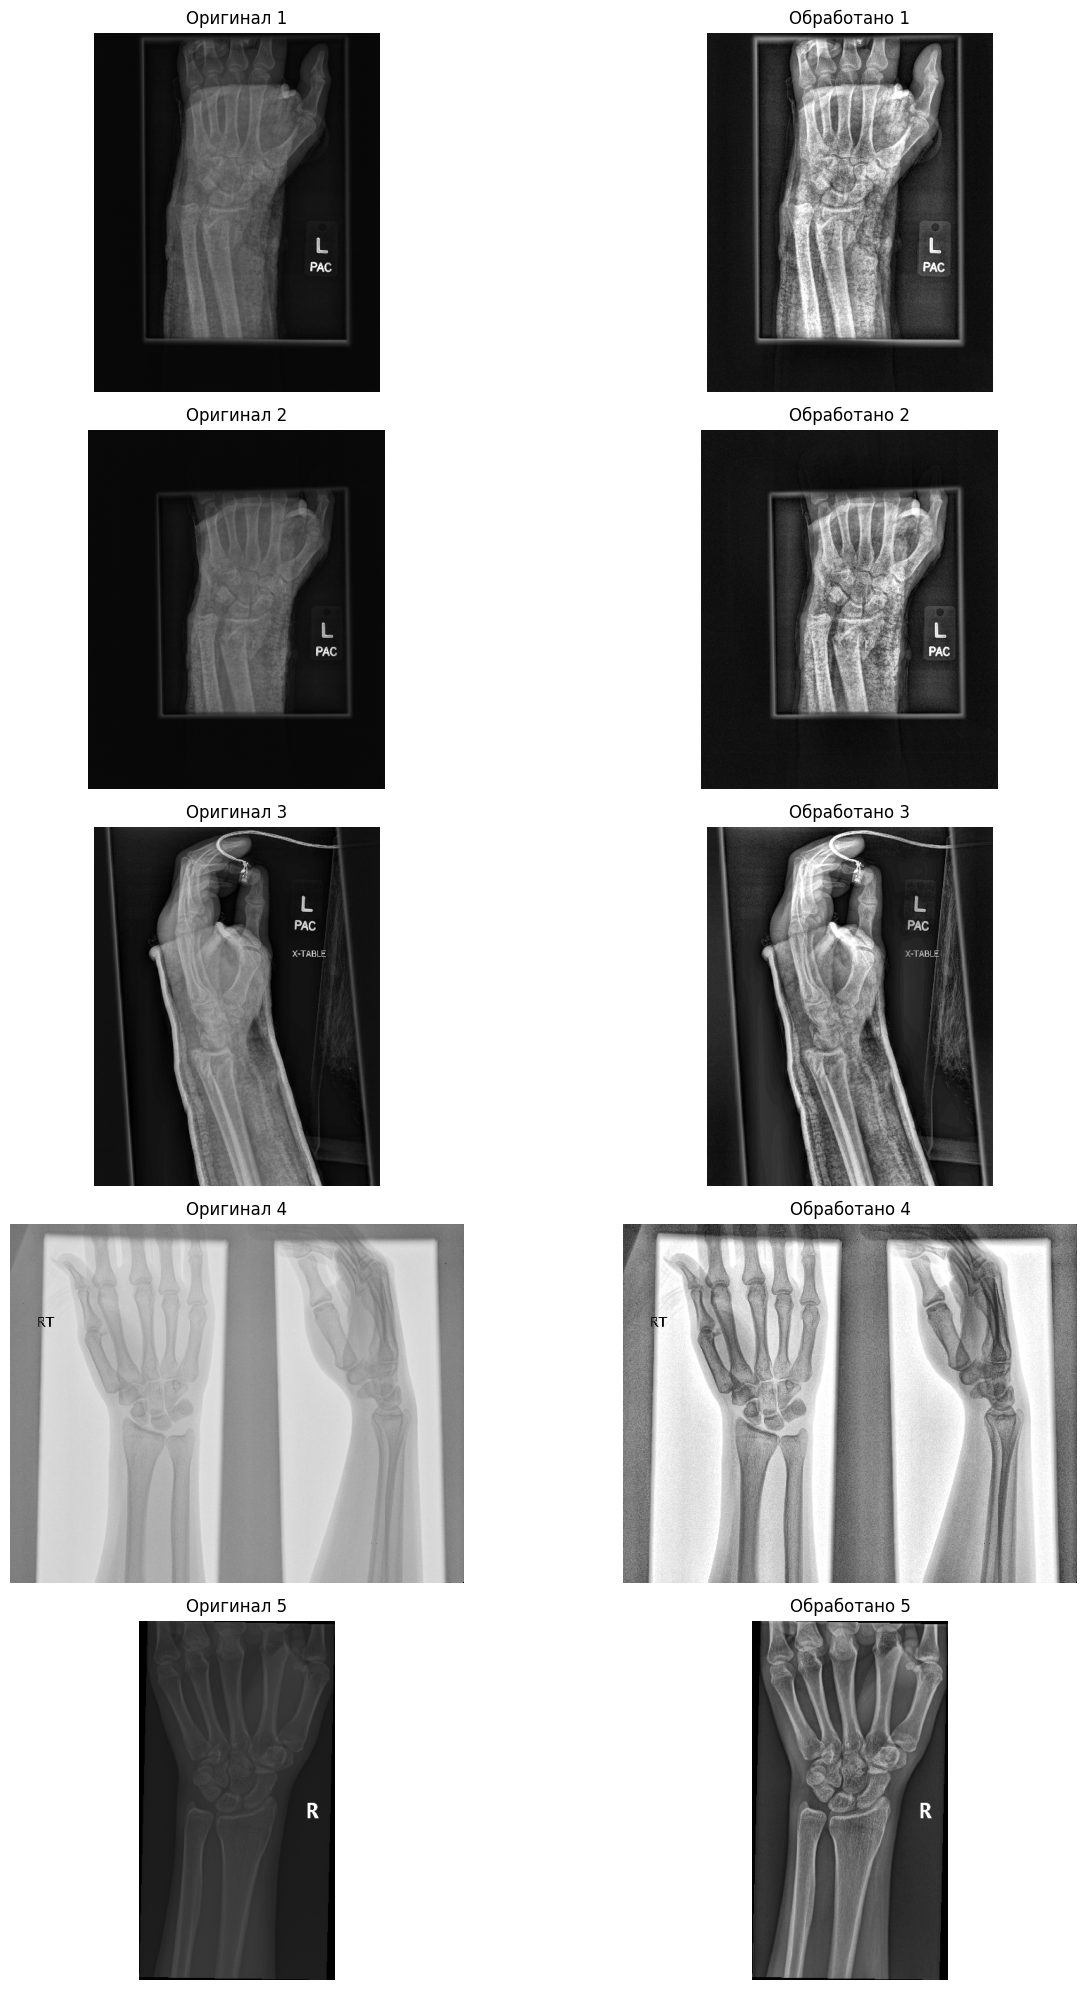

In [ ]:
low_contrast_df = brightness_df.sort_values(by='std').head(5)

#выводим примеры изображений до/после
def enhance_comparison(paths, n=5):
    plt.figure(figsize=(14, 4 * n))

    for i, path in enumerate(paths[:n]):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        brightness = np.mean(img)
        contrast = np.std(img)

        alpha, beta, clip_limit = parameters(brightness, contrast)
        tile_grid_size = (8, 8)

        # CLAHE + контраст/яркость
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        img_clahe = clahe.apply(img)
        enhanced = cv2.convertScaleAbs(img_clahe, alpha=alpha, beta=beta)

        # Оригинал
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Оригинал {i+1}')
        plt.axis('off')

        # Обработанное
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(enhanced, cmap='gray')
        plt.title(f'Обработано {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


enhance_comparison(valid_paths)

#### Невооруженным взглядом можно заметить, что контраст и читаемость изображений улучшились.


#### Применим функцию обработки к сформированному датасету

In [ ]:
process_images(brightness_df,image_dir, 'MURA-enhanced')

Обработка изображений: 100%|██████████| 40005/40005 [08:47<00:00, 75.87it/s]


#### Проанализируем контрастность и яркость обработанного датасета.

In [ ]:
#загружаем обработанный датасет
# датасет
enhanced_image_dir = 'MURA-enhanced'

#Пути к файлам
enhanced_paths = []
for root, dirs, files in os.walk(enhanced_image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            enhanced_paths.append(os.path.join(root, file))

In [ ]:
enhanced_brightness_data = []

for path in tqdm(enhanced_paths, desc='Извлечение статистики яркости после обработки'):
    stats = get_brightness_stats(path)
    if stats:
        enhanced_brightness_data.append({**stats, 'path': path})

enhanced_brightness = pd.DataFrame(enhanced_brightness_data)
print(enhanced_brightness.describe())

Извлечение статистики яркости после обработки: 100%|██████████| 40005/40005 [03:47<00:00, 175.55it/s]


                min           max          mean           std         range
count  40005.000000  40005.000000  40005.000000  40005.000000  40005.000000
mean      17.834271    253.911986     90.763086     45.683371    236.077715
std        9.582007      6.498266     23.480245     10.412076     11.423062
min        0.000000     40.000000     25.003286      0.412349     19.000000
25%       12.000000    255.000000     77.854983     38.186903    232.000000
50%       14.000000    255.000000     87.572530     44.741267    240.000000
75%       23.000000    255.000000     99.596634     52.592392    242.000000
max      135.000000    255.000000    229.152581    103.841105    255.000000


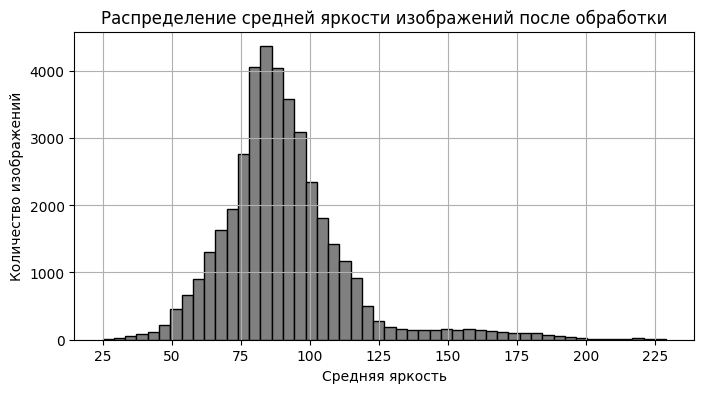

In [ ]:
# Гистограмма средней яркости
plt.figure(figsize=(8,4))
plt.hist(enhanced_brightness['mean'], bins=50, color='gray', edgecolor='black')
plt.title('Распределение средней яркости изображений после обработки')
plt.xlabel('Средняя яркость')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

Среднее значение яркости увеличилось, что улучшило визуальное восприятие деталей.

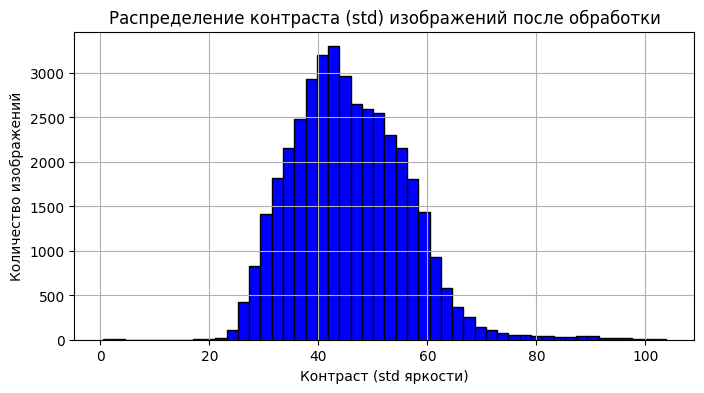

In [ ]:
# Гистограмма стандартного отклонения (контраста)
plt.figure(figsize=(8,4))
plt.hist(enhanced_brightness['std'], bins=50, color='blue', edgecolor='black')
plt.title('Распределение контраста (std) изображений после обработки')
plt.xlabel('Контраст (std яркости)')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

 Std вырос, особенно у изображений c совсем низким контрастом. Такое улучшение сделает границы и структуры более различимыми.

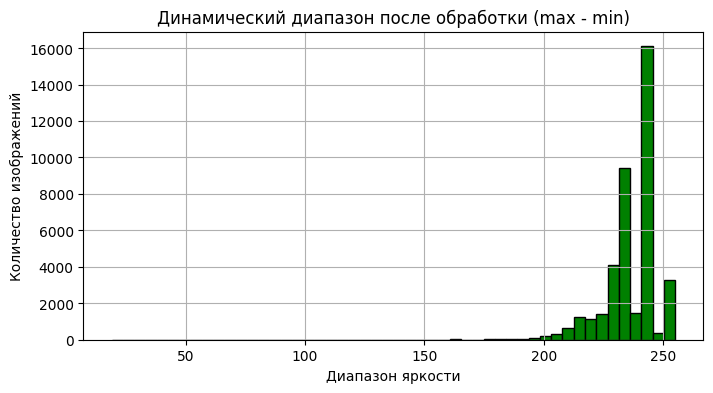

In [ ]:
# Гистограмма динамического диапазона (max - min)
plt.figure(figsize=(8,4))
plt.hist(enhanced_brightness['range'], bins=50, color='green', edgecolor='black')
plt.title('Динамический диапазон после обработки (max - min)')
plt.xlabel('Диапазон яркости')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

На графике преобладают значения в диапазоне 230–255. Это говорит о том, что изображения охватывают почти весь возможный спектр яркости, что Отсутствие большого числа с узким диапазоном (ниже 200) — указывает на устранение «плоских» и недоэкспонированных изображений, в сравнении с первоначальными данными.

#### Посмотрим резкость изображений после обработки

In [ ]:
#функция определения резкости из EDA
def compute_blur_score(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return laplacian_var

enhanced_blur_scores = []

for i, row in tqdm(enhanced_brightness.iterrows(), total=len(enhanced_brightness), desc='Извлечение статистики размытия после обработки'):
    score = compute_blur_score(row['path'])
    if score is not None:
        enhanced_blur_scores.append({'path': row['path'], 'blur_var': score})
enhanced_blur_df = pd.DataFrame(enhanced_blur_scores)


Извлечение статистики размытия после обработки: 100%|██████████| 40005/40005 [05:26<00:00, 122.49it/s]


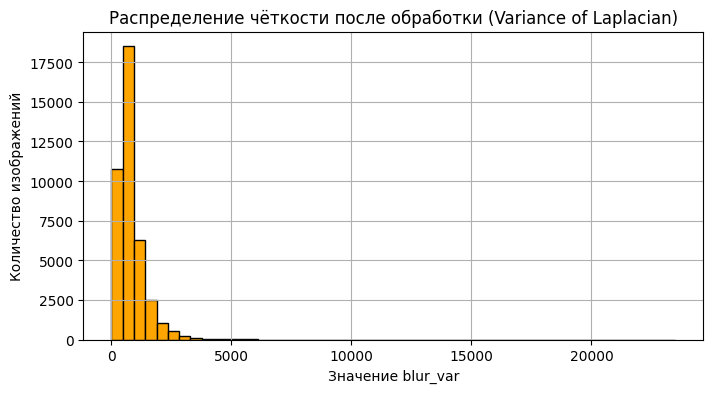

In [ ]:
# Визуализация
plt.figure(figsize=(8,4))
plt.hist(enhanced_blur_df['blur_var'], bins=50, color='orange', edgecolor='black')
plt.title("Распределение чёткости после обработки (Variance of Laplacian)")
plt.xlabel("Значение blur_var")
plt.ylabel("Количество изображений")
plt.grid(True)
plt.show()

Распределение blur_var показывает, что большинство изображений имеют достаточную чёткость.

In [ ]:
# доля потенциально размытых изображений
num_blurry = (enhanced_blur_df['blur_var'] < 50).sum()
total = len(enhanced_blur_df)
print(f"🔍 Сильно размытых изображений: {num_blurry} из {total} ({num_blurry/total:.2%})")

🔍 Сильно размытых изображений: 2 из 40005 (0.00%)


In [ ]:
image_dir = Path("MURA-enhanced")   # корень с исходными картинками
extensions = {".png", ".jpg", ".jpeg"}  # на всякий случай

def collect_image_dimensions(root_dir: Path):
    records = []
    for path in root_dir.rglob("*"):
        if path.suffix.lower() in extensions and not path.name.startswith("._"):
            try:
                with Image.open(path) as img:
                    w, h = img.size
            except Exception as e:
                print(f"⚠️ Ошибка при чтении {path}: {e}")
                continue
            records.append(
                {
                    "path": path,
                    "width": w,
                    "height": h,
                    "aspect_ratio": w / h if h != 0 else np.nan,
                }
            )
    df = pd.DataFrame(records)
    print(f"Всего найдено изображений: {len(df)}")
    return df

df_dimensions = collect_image_dimensions(image_dir)
display(df_dimensions.head())


Всего найдено изображений: 40005


,path,width,height,aspect_ratio
0,MURA-enhanced/valid/XR_FINGER/patient11899/stu...,263,512,0.513672
1,MURA-enhanced/valid/XR_FINGER/patient11899/stu...,266,512,0.519531
2,MURA-enhanced/valid/XR_FINGER/patient11899/stu...,263,512,0.513672
3,MURA-enhanced/valid/XR_FINGER/patient11424/stu...,193,512,0.376953
4,MURA-enhanced/valid/XR_FINGER/patient11424/stu...,161,512,0.314453


In [ ]:
X = df_dimensions[["aspect_ratio"]].values

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init="auto"  # если sklearn>=1.4, иначе можно убрать этот параметр
)

df_dimensions["ar_cluster"] = kmeans.fit_predict(X)

cluster_stats = (
    df_dimensions
    .groupby("ar_cluster")
    .agg(
        count=("aspect_ratio", "size"),
        mean_ar=("aspect_ratio", "mean"),
        median_ar=("aspect_ratio", "median"),
        std_ar=("aspect_ratio", "std"),
        mean_w=("width", "mean"),
        median_w=("width", "median"),
        std_w=("width", "std"),
        mean_h=("height", "mean"),
        median_h=("height", "median"),
        std_h=("height", "std"),
    )
)
display(cluster_stats)

,count,mean_ar,median_ar,std_ar,mean_w,median_w,std_w,mean_h,median_h,std_h
ar_cluster,,,,,,,,,,
0,7785,1.293487,1.261084,0.247560,512.000000,512.0,0.000000,404.153243,406.0,46.086209
1,23995,0.806505,0.792969,0.077577,412.657512,406.0,38.975324,511.735195,512.0,2.002285
2,8225,0.496859,0.511719,0.102084,254.391733,262.0,52.266841,512.000000,512.0,0.000000


In [ ]:
# Размеры, рекомендованные chatgpt как более оптимальные
# TARGET_H = 256
# TARGET_W = 320
TARGET_H = 224
TARGET_W = 224

def resize_with_padding(img: Image.Image,
                        target_h: int = TARGET_H,
                        target_w: int = TARGET_W) -> Image.Image:
    """
    Ресайз изображения с сохранением пропорций + центрированный паддинг
    до (target_h, target_w).
    """
    w, h = img.size

    # Первый шаг: пробуем масштабировать по высоте
    if h > 0:
        scale = target_h / h
    else:
        scale = 1.0

    new_w = int(round(w * scale))
    new_h = int(round(h * scale))

    # Если по высоте всё хорошо, но ширина вдруг слишком большая — масштабируем по ширине
    if new_w > target_w:
        scale = target_w / w
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))

    # Собственно ресайз
    img_resized = img.resize((new_w, new_h), Image.BILINEAR)

    # Паддинг до нужного размера
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top

    # Фон чёрный (0), под рентгены как раз
    img_padded = ImageOps.expand(
        img_resized,
        border=(pad_left, pad_top, pad_right, pad_bottom),
        fill=0
    )

    return img_padded


In [ ]:
output_root = Path(f"MURA-v1.1-resized-{TARGET_W}x{TARGET_H}")
output_root.mkdir(parents=True, exist_ok=True)

def save_resized_dataset(df: pd.DataFrame,
                         input_root: Path,
                         output_root: Path):
    num_saved = 0
    for i, row in df.iterrows():
        src_path: Path = row["path"]
        rel_path = src_path.relative_to(input_root)  # относительный путь от корня
        dst_path = output_root / rel_path

        dst_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            with Image.open(src_path) as img:
                img = img.convert("L")  # на всякий случай делаем grayscale
                img_resized = resize_with_padding(img)
                img_resized.save(dst_path)
            num_saved += 1
        except Exception as e:
            print(f"⚠️ Ошибка при обработке {src_path}: {e}")

    print(f"Готово! Сохранено изображений: {num_saved}")

save_resized_dataset(df_dimensions, image_dir, output_root)


Готово! Сохранено изображений: 40005



=== Кластер 0 ===


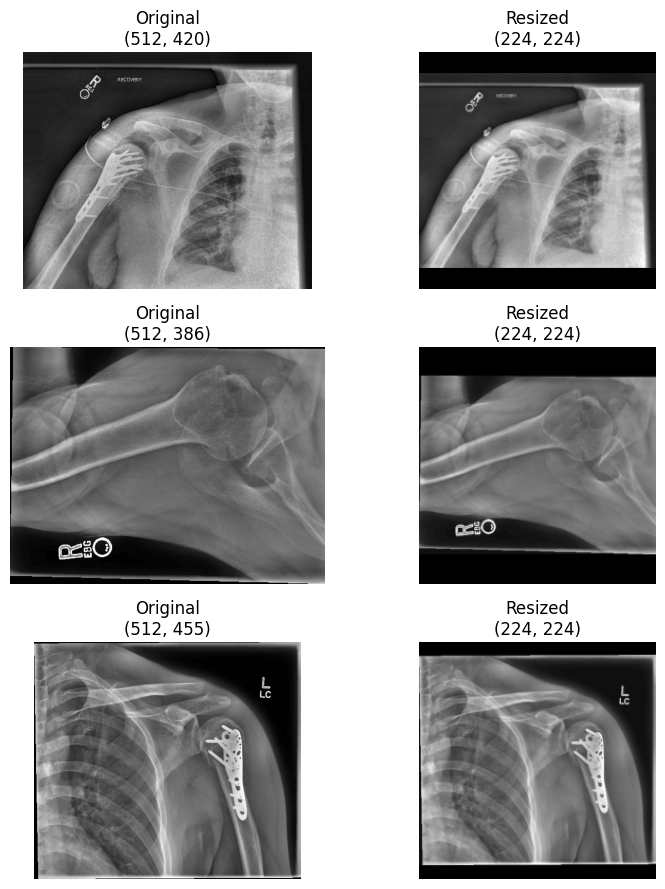


=== Кластер 1 ===


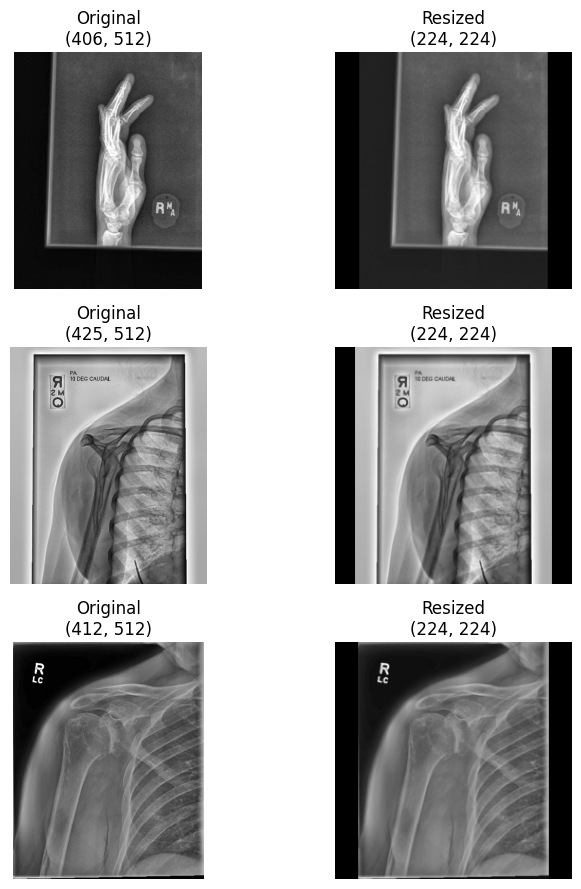


=== Кластер 2 ===


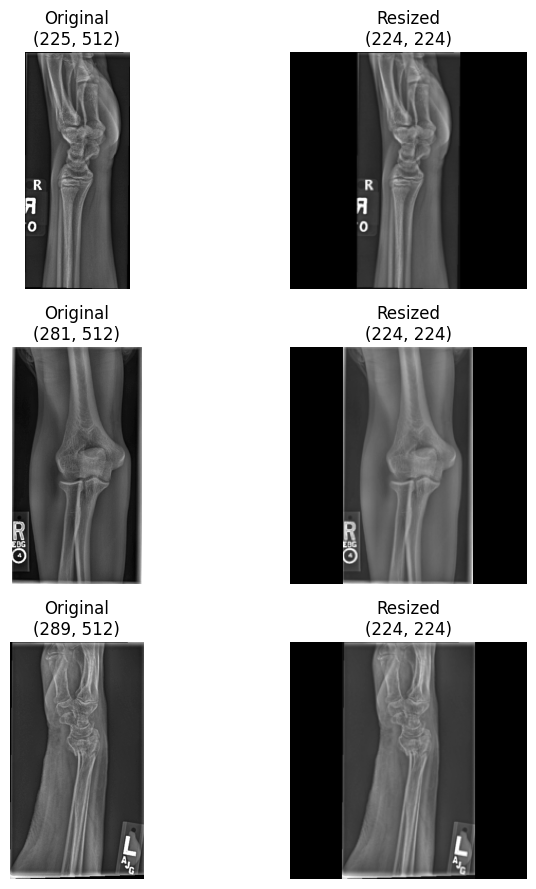

In [ ]:
def show_cluster_examples(df: pd.DataFrame,
                          input_root: Path,
                          output_root: Path,
                          samples_per_cluster: int = 3):
    clusters = sorted(df["ar_cluster"].dropna().unique())
    for cl in clusters:
        print(f"\n=== Кластер {cl} ===")
        df_cl = df[df["ar_cluster"] == cl].sample(
            n=min(samples_per_cluster, (df["ar_cluster"] == cl).sum()),
            random_state=42
        )

        fig, axes = plt.subplots(
            nrows=samples_per_cluster,
            ncols=2,
            figsize=(8, 3 * samples_per_cluster)
        )

        if samples_per_cluster == 1:
            axes = np.array([axes])  # чтобы всегда была 2D-матрица

        for row_idx, (_, row) in enumerate(df_cl.iterrows()):
            src_path: Path = row["path"]
            rel_path = src_path.relative_to(input_root)
            dst_path = output_root / rel_path

            # Оригинал
            try:
                with Image.open(src_path) as img_orig:
                    axes[row_idx, 0].imshow(img_orig, cmap="gray")
                    axes[row_idx, 0].set_title(f"Original\n{img_orig.size}")
                    axes[row_idx, 0].axis("off")
            except Exception as e:
                axes[row_idx, 0].set_title(f"Ошибка чтения\n{src_path}")
                axes[row_idx, 0].axis("off")

            # Ресайз
            try:
                with Image.open(dst_path) as img_resized:
                    axes[row_idx, 1].imshow(img_resized, cmap="gray")
                    axes[row_idx, 1].set_title(f"Resized\n{img_resized.size}")
                    axes[row_idx, 1].axis("off")
            except Exception as e:
                axes[row_idx, 1].set_title(f"Нет файла\n{dst_path}")
                axes[row_idx, 1].axis("off")

        plt.tight_layout()
        plt.show()

show_cluster_examples(df_dimensions, image_dir, output_root, samples_per_cluster=3)

### Обучим на предобработанных данных линейные модели

#### Импорты и пути

In [ ]:
DATA_ROOT = "MURA-v1.1-resized-224x224"
assert os.path.exists(DATA_ROOT), f"Папка {DATA_ROOT} не найдена. Укажите правильный путь."

#### Функции парсинга и загрузки данных

In [ ]:
def parse_study_path(study_path: str):
    parts = Path(study_path).parts
    split = parts[-4]
    anatomy = parts[-3]
    patient_id = parts[-2]
    study_name = parts[-1]
    label = 1 if 'positive' in study_name else 0
    return {
        'split': split,
        'anatomy': anatomy,
        'patient_id': patient_id,
        'study_id': study_name,
        'label': label,
        'path': study_path
    }

def build_dataframe(root_dir: str):
    records = []
    for split in ['train', 'valid']:
        split_path = os.path.join(root_dir, split)
        if not os.path.isdir(split_path):
            continue
        for anatomy in os.listdir(split_path):
            anatomy_path = os.path.join(split_path, anatomy)
            if not os.path.isdir(anatomy_path):
                continue
            for patient in os.listdir(anatomy_path):
                patient_path = os.path.join(anatomy_path, patient)
                for study in os.listdir(patient_path):
                    study_path = os.path.join(patient_path, study)
                    if os.path.isdir(study_path):
                        records.append(parse_study_path(study_path))
    return pd.DataFrame(records)

# Загрузка основного датафрейма
df = build_dataframe(DATA_ROOT)
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'valid']
print(f"Загружено {len(df)} исследований от {df['patient_id'].nunique()} пациентов.")

Загружено 14656 исследований от 11967 пациентов.


#### Функция извлечения признаков

In [ ]:
def extract_intensity_features_from_study(study_path):
    study_dir = Path(study_path)
    image_files = list(study_dir.glob("*.png")) + list(study_dir.glob("*.jpg"))
    if not image_files:
        raise FileNotFoundError(f"Нет изображений в: {study_dir}")
    img_path = image_files[0]
    img = Image.open(img_path).convert('L')
    flat = np.array(img).ravel().astype(np.float32) / 255.0
    return {
        'mean': np.mean(flat),
        'std': np.std(flat),
        'median': np.median(flat),
        'skewness': skew(flat),
        'kurtosis': kurtosis(flat),
        'entropy': entropy(np.histogram(flat, bins=64, density=True)[0] + 1e-8),
        'p90': np.percentile(flat, 90),
        'p10': np.percentile(flat, 10)
    }

#### Функция подготовки данных

In [ ]:
def prepare_data_for_anatomy(train_subset, val_subset, extract_func):
    # Извлечение признаков
    X_train_list, y_train_list = [], []
    for _, row in train_subset.iterrows():
        try:
            feats = extract_func(row['path'])
            X_train_list.append(feats)
            y_train_list.append(row['label'])
        except Exception:
            continue

    X_val_list, y_val_list = [], []
    for _, row in val_subset.iterrows():
        try:
            feats = extract_func(row['path'])
            X_val_list.append(feats)
            y_val_list.append(row['label'])
        except Exception:
            continue

    if len(X_train_list) == 0 or len(X_val_list) == 0:
        return None, None, None, None

    # Преобразуем в датафреймы/массивы
    X_train = pd.DataFrame(X_train_list)
    y_train = np.array(y_train_list, dtype=int)
    X_val = pd.DataFrame(X_val_list)
    y_val = np.array(y_val_list, dtype=int)
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

    # Шкалирование
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    return X_train_scaled, y_train, X_val_scaled, y_val

#### Функция оценки модели

In [ ]:
def evaluate_model_on_val(model, X_val_scaled, y_val):
    """Оценка модели на валидационных данных."""
    y_pred = model.predict(X_val_scaled)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
    kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

    return acc, f1, kappa

#### Обучение моделей без подбора параметров

In [ ]:
fixed_models = {
    'LogisticRegression_Fixed': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'RidgeClassifier_Fixed': RidgeClassifier(random_state=42, class_weight='balanced'),
    'LinearSVC_Fixed': LinearSVC(random_state=42, class_weight='balanced', max_iter=10000)
}

results_fixed = []
for anatomy in sorted(df['anatomy'].unique()):
    print(f"\nОбработка (FIXED): {anatomy}")

    train_subset = train_df[train_df['anatomy'] == anatomy].copy()
    val_subset = val_df[val_df['anatomy'] == anatomy].copy()

    if len(train_subset) < 10 or len(val_subset) < 5:
        print(f"  Пропущено: мало данных")
        continue

    X_train_scaled, y_train, X_val_scaled, y_val = prepare_data_for_anatomy(train_subset, val_subset, extract_intensity_features_from_study)

    if X_train_scaled is None:
        print(f"  Пропущено: не удалось извлечь признаки")
        continue

    for model_name_fixed, model_instance in fixed_models.items():
        model_instance.fit(X_train_scaled, y_train)
        acc, f1, kappa = evaluate_model_on_val(model_instance, X_val_scaled, y_val)

        results_fixed.append({
            'Anatomy': anatomy,
            'Model': model_name_fixed,
            'Train_N': len(X_train_scaled),
            'Val_N': len(X_val_scaled),
            'Val_Abnormal': int(np.sum(y_val == 1)),
            'Accuracy': acc,
            'F1_Abnormal': f1,
            'Cohen_Kappa': kappa
        })

        print(f"  {model_name_fixed}: Val Kappa = {kappa:.3f}")

# Анализ результатов фиксированных параметров

    df_fixed = pd.DataFrame(results_fixed)
    mean_kappa_fixed = df_fixed.groupby('Model')['Cohen_Kappa'].mean().sort_values(ascending=False)
    print("\nСРЕДНИЙ KAPPA ПО МОДЕЛЯМ (ФИКСИРОВАННЫЕ ПАРАМЕТРЫ)")
    for model_name, avg_kappa in mean_kappa_fixed.items():
        print(f"{model_name}: {avg_kappa:.3f}")


Обработка (FIXED): XR_ELBOW
  LogisticRegression_Fixed: Val Kappa = 0.025
  RidgeClassifier_Fixed: Val Kappa = 0.025
  LinearSVC_Fixed: Val Kappa = 0.025

СРЕДНИЙ KAPPA ПО МОДЕЛЯМ (ФИКСИРОВАННЫЕ ПАРАМЕТРЫ)
LinearSVC_Fixed: 0.025
LogisticRegression_Fixed: 0.025
RidgeClassifier_Fixed: 0.025

Обработка (FIXED): XR_FINGER
  LogisticRegression_Fixed: Val Kappa = 0.415
  RidgeClassifier_Fixed: Val Kappa = 0.438
  LinearSVC_Fixed: Val Kappa = 0.438

СРЕДНИЙ KAPPA ПО МОДЕЛЯМ (ФИКСИРОВАННЫЕ ПАРАМЕТРЫ)
LinearSVC_Fixed: 0.232
RidgeClassifier_Fixed: 0.232
LogisticRegression_Fixed: 0.220

Обработка (FIXED): XR_FOREARM
  LogisticRegression_Fixed: Val Kappa = 0.201
  RidgeClassifier_Fixed: Val Kappa = 0.185
  LinearSVC_Fixed: Val Kappa = 0.185

СРЕДНИЙ KAPPA ПО МОДЕЛЯМ (ФИКСИРОВАННЫЕ ПАРАМЕТРЫ)
LinearSVC_Fixed: 0.216
RidgeClassifier_Fixed: 0.216
LogisticRegression_Fixed: 0.214

Обработка (FIXED): XR_HAND
  LogisticRegression_Fixed: Val Kappa = 0.053
  RidgeClassifier_Fixed: Val Kappa = 0.053
  Linea

#### Определение параметров и функция GridSearchCV

In [ ]:
kappa_scorer = make_scorer(cohen_kappa_score, greater_is_better=True, weights='quadratic')

models_and_params = {
    'LogisticRegression': {
        'class': LogisticRegression,
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    'RidgeClassifier': {
        'class': RidgeClassifier,
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    'LinearSVC': {
        'class': LinearSVC,
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'dual': ['auto'],
            'max_iter': [10000]
        }
    }
}

# Функция для GridSearchCV
def run_gridsearch_for_anatomy(anatomy, train_df, val_df, model_class, param_grid, extract_func, model_name):
    """Запуск GridSearchCV для одного анатомического участка, оптимизируя по Cohen's Kappa."""
    print(f"\nОбработка {model_name}: {anatomy}")

    train_subset = train_df[train_df['anatomy'] == anatomy].copy()
    val_subset = val_df[val_df['anatomy'] == anatomy].copy()

    if len(train_subset) < 10 or len(val_subset) < 5:
        print(f"  Пропущено: мало данных")
        return None

    X_train_scaled, y_train, X_val_scaled, y_val = prepare_data_for_anatomy(train_subset, val_subset, extract_func)

    if X_train_scaled is None:
        print(f"  Пропущено: не удалось извлечь признаки")
        return None

    # GridSearchCV
    print(f"    Запуск GridSearchCV (оптимизация по Cohen's Kappa)...")
    gs_model = model_class(random_state=42, class_weight='balanced', max_iter=10000)
    # Используем заранее созданный scorer
    grid_search = GridSearchCV(gs_model, param_grid, cv=5, scoring=kappa_scorer, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    print(f"    Лучшие параметры: {grid_search.best_params_}")
    print(f"    Лучший CV Cohen's Kappa: {grid_search.best_score_:.3f}")

    # Оценка ЛУЧШЕЙ модели на валидации
    acc, f1, kappa = evaluate_model_on_val(best_model, X_val_scaled, y_val)

    result_dict = {
        'Anatomy': anatomy,
        'Model': f'{model_name}_GridSearch',
        'Train_N': len(X_train_scaled),
        'Val_N': len(X_val_scaled),
        'Val_Abnormal': int(np.sum(y_val == 1)),
        'Accuracy': acc,
        'F1_Abnormal': f1,
        'Cohen_Kappa': kappa,
        'Best_Params': str(grid_search.best_params_),
        'CV_Best_Score': grid_search.best_score_
    }

    print(f"  Train: {result_dict['Train_N']}, Val: {result_dict['Val_N']}, Val Kappa = {kappa:.3f}")
    return result_dict

#### Основной цикл GridSearchCV

In [ ]:
all_results_optimized = []
for model_name, config in models_and_params.items():
    model_class = config['class']
    param_grid = config['params']
    results_for_model = []
    for anatomy in sorted(df['anatomy'].unique()):
        result = run_gridsearch_for_anatomy(anatomy, train_df, val_df, model_class, param_grid, extract_intensity_features_from_study, model_name)
        if result:
            results_for_model.append(result)
            all_results_optimized.append(result)

    # Вывод результатов для текущей модели
    if results_for_model:
        results_df = pd.DataFrame(results_for_model)
        print(f"\n{model_name} GRIDSEARCHCV")
        print(results_df[['Anatomy', 'Cohen_Kappa', 'Best_Params']].to_string(index=False, float_format="%.3f"))


Обработка LogisticRegression: XR_ELBOW
    Запуск GridSearchCV (оптимизация по Cohen's Kappa)...
    Лучшие параметры: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
    Лучший CV Cohen's Kappa: 0.125
  Train: 1754, Val: 158, Val Kappa = 0.012

Обработка LogisticRegression: XR_FINGER
    Запуск GridSearchCV (оптимизация по Cohen's Kappa)...
    Лучшие параметры: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
    Лучший CV Cohen's Kappa: 0.305
  Train: 1935, Val: 175, Val Kappa = 0.415

Обработка LogisticRegression: XR_FOREARM
    Запуск GridSearchCV (оптимизация по Cohen's Kappa)...
    Лучшие параметры: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
    Лучший CV Cohen's Kappa: 0.172
  Train: 877, Val: 133, Val Kappa = 0.170

Обработка LogisticRegression: XR_HAND
    Запуск GridSearchCV (оптимизация по Cohen's Kappa)...
    Лучшие параметры: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
    Лучший CV Cohen's Kappa: 0.061
  Train: 2018, Val: 167, Val Kappa = 0.028



#### Финальное сравнение

In [ ]:
comparison_optimized_df = pd.DataFrame(all_results_optimized)

# Преобразуем DataFrame
pivoted_kappa = comparison_optimized_df.pivot(index='Anatomy', columns='Model', values='Cohen_Kappa')
pivoted_params = comparison_optimized_df.pivot(index='Anatomy', columns='Model', values='Best_Params')

# Найем лучшую модель для каждого анатомического участка
best_model_per_anatomy = pivoted_kappa.idxmax(axis=1)
best_kappa_per_anatomy = pivoted_kappa.max(axis=1)

# Найдем параметры лучшей модели для каждого участка
best_params_for_summary = []
for anatomy in best_model_per_anatomy.index:
    best_model_name = best_model_per_anatomy.loc[anatomy]
    best_params_str = pivoted_params.loc[anatomy, best_model_name]
    best_params_for_summary.append(best_params_str)

print("\ЛУЧШИЕ МОДЕЛИ ПО АНАТОМИЧЕСКИМ УЧАСТКАМ (ПОСЛЕ GRIDSEARCHCV ПО KAPPA)")
print("Признаки: статистика интенсивности (1 изображение на исследование)")
best_results_summary = pd.DataFrame({
    'Best_Model': best_model_per_anatomy,
    'Best_Cohen_Kappa': best_kappa_per_anatomy,
    'Best_Params': best_params_for_summary
})
best_results_summary = best_results_summary.sort_values('Best_Cohen_Kappa', ascending=False)
print(best_results_summary.to_string())

\ЛУЧШИЕ МОДЕЛИ ПО АНАТОМИЧЕСКИМ УЧАСТКАМ (ПОСЛЕ GRIDSEARCHCV ПО KAPPA)
Признаки: статистика интенсивности (1 изображение на исследование)
                             Best_Model  Best_Cohen_Kappa                                                   Best_Params
Anatomy                                                                                                                
XR_FINGER          LinearSVC_GridSearch          0.438184  {'C': 1, 'dual': 'auto', 'max_iter': 10000, 'penalty': 'l2'}
XR_HUMERUS         LinearSVC_GridSearch          0.318481  {'C': 1, 'dual': 'auto', 'max_iter': 10000, 'penalty': 'l2'}
XR_SHOULDER  RidgeClassifier_GridSearch          0.308838                                                {'alpha': 100}
XR_WRIST     RidgeClassifier_GridSearch          0.224348                                              {'alpha': 0.001}
XR_FOREARM   RidgeClassifier_GridSearch          0.184975                                              {'alpha': 0.001}
XR_ELBOW     RidgeClas

#### Построим тепловую карту

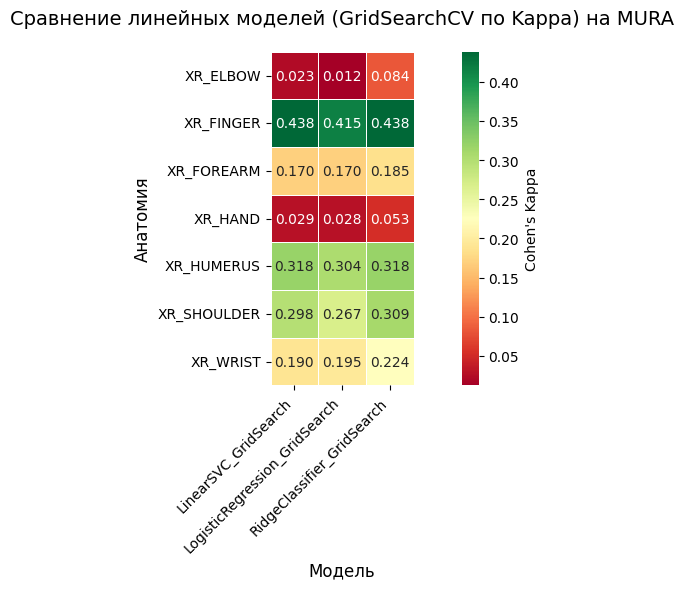

In [ ]:
model_columns = [col for col in pivoted_kappa.columns if col.endswith('_GridSearch')]
heatmap_data = pivoted_kappa[model_columns]

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    cbar_kws={'label': 'Cohen\'s Kappa'},
    linewidths=0.5,
    square=True
)

plt.title("Сравнение линейных моделей (GridSearchCV по Kappa) на MURA", fontsize=14, pad=20)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("Анатомия", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

#### Обучение XGBoost + дополнительные признаки(CLAHE + HOG + LBP + PCA)

In [ ]:
# загрузка
IMAGE_ROOT_DIR = "MURA-v1.1-resized-224x224"
folders_path = build_dataframe(IMAGE_ROOT_DIR)

#Пути к файлам
img_paths = []
for root, dirs, files in os.walk(IMAGE_ROOT_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_paths.append(os.path.join(root, file))

In [ ]:
# Параметры обработки
IMG_SIZE = (224, 224)
IMPLANT_THRESH = 250
MIN_IMPLANT_AREA = 50

# Настройки LBP
LBP_POINTS = 24       # Количество точек
LBP_RADIUS = 3        # Радиус охвата (3 пикселя)
LBP_METHOD = 'uniform'

# Настройки PCA
PCA_COMPONENTS = 50   # Сжимаем визуальные признаки до 50 главных чисел

Необходимые функции

In [ ]:
# Превращает таблицу исследований в таблицу картинок, подставляя IMG_ROOT_DIR и находит PNG/JPG в подпапке.

def expand_studies_to_images(df_studies):
    image_records = []
    missing = 0

    for _, row in tqdm(df_studies.iterrows(), total=len(df_studies)):
        study_path = os.path.normpath(row['path'])  # исправляет \ на /

        if not os.path.isdir(study_path):
            missing += 1
            continue

        for f in os.listdir(study_path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_records.append({
                    'path': os.path.join(study_path, f),
                    'label': row['label'],
                    'anatomy': row['anatomy'],
                    'split': row['split']
                })

    print(f"Пропущено {missing} папок (не найдены).")
    return pd.DataFrame(image_records)


In [ ]:
# извлечение признаков

def extract_visual_features(img):
    """
    Извлекает "тяжелые" вектора: HOG + LBP
    """
    # 1. HOG (Полный вектор, не среднее!)
    # pixels_per_cell=(32, 32) дает меньше признаков, чем (16,16), но быстрее.
    # feature_vector=True возвращает длинный массив чисел
    hog_vector = hog(img, pixels_per_cell=(32, 32), cells_per_block=(2, 2), visualize=False, feature_vector=True)

    # 2. LBP (Гистограмма текстуры)
    lbp = local_binary_pattern(img, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    # Считаем гистограмму LBP значений
    n_bins = LBP_POINTS + 2
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # Объединяем HOG и LBP в один длинный вектор
    return np.concatenate([hog_vector, lbp_hist])

In [ ]:
# извлечение статистики и метаданных
def extract_statistical_features(img, img_path, anatomy):

    # Нормализация
    flat = img.ravel().astype(np.float32) / 255.0

    feats = {}
    feats['anatomy'] = anatomy # Категория

    # Статистика
    feats['mean'] = np.mean(flat)
    feats['std'] = np.std(flat)
    feats['skew'] = skew(flat)
    feats['kurt'] = kurtosis(flat)
    feats['entropy'] = entropy(np.histogram(flat, bins=64, density=True)[0] + 1e-8)

    # GLCM (на всем изображении для простоты)
    # Для GLCM нужно uint8 0..255
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/2], levels=256, symmetric=True, normed=True)
    feats['glcm_contrast'] = graycoprops(glcm, 'contrast').mean()
    feats['glcm_energy'] = graycoprops(glcm, 'energy').mean()

    return feats

In [ ]:
# функция обработки
def process_row(row):
    path = row['path']
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    except: return None
    if img is None: return None
    if img.shape != IMG_SIZE: img = cv2.resize(img, IMG_SIZE)

    # Извлекаем ДВА типа признаков
    visual_vec = extract_visual_features(img) # Это пойдет в PCA
    stats_dict = extract_statistical_features(img, path, row['anatomy']) # Это пойдет напрямую

    return visual_vec, stats_dict

Извлечение статистики

In [ ]:

print(" Извлекаем HOG, LBP, GLCM и Статистику...")
visual_data = [] # Список векторов
stats_data = []  # Список словарей
labels = []


df_img = expand_studies_to_images(folders_path)
print("Готово изображений:", len(df_img))

# Используем цикл, чтобы удобно разделять потоки данных
count = 0
for idx, row in tqdm(df_img.iterrows(), total=len(df_img)):
    res = process_row(row)
    if res:
        vis_vec, stat_dict = res
        visual_data.append(vis_vec)
        stats_data.append(stat_dict)
        labels.append(row['label'])
        count += 1
    else:
        print("Нет признаков для:", row['path'])
print("Успешно обработано:", count)

 Извлекаем HOG, LBP, GLCM и Статистику...


100%|██████████| 14656/14656 [00:02<00:00, 6583.63it/s]


Пропущено 0 папок (не найдены).
Готово изображений: 40005


100%|██████████| 40005/40005 [42:57<00:00, 15.52it/s]

Успешно обработано: 40005


In [ ]:
# Преобразуем в массивы
lengths = [len(v) for v in visual_data]
print("Уникальные длины визуальных векторов:", set(lengths))

X_visual = np.array(visual_data) # Большая матрица (N_samples x ~3000 features)
df_stats = pd.DataFrame(stats_data)
y = np.array(labels)

print(f" Размер визуальной матрицы (до PCA): {X_visual.shape}")

Уникальные длины визуальных векторов: {1322}
 Размер визуальной матрицы (до PCA): (40005, 1322)


PCA (Сжатие визуальных признаков)

In [ ]:
# Сначала скейлинг (PCA чувствителен к масштабу)
scaler = StandardScaler()
X_visual_scaled = scaler.fit_transform(X_visual)

# Сам PCA
pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
X_pca = pca.fit_transform(X_visual_scaled)

print(f" Размер после PCA: {X_pca.shape}")
print(f"   Объясненная дисперсия (сколько инфы сохранили): {sum(pca.explained_variance_ratio_):.2%}")

# Создаем DataFrame из PCA компонент
pca_cols = [f'pca_{i}' for i in range(PCA_COMPONENTS)]
df_pca = pd.DataFrame(X_pca, columns=pca_cols)

 Размер после PCA: (40005, 50)
   Объясненная дисперсия (сколько инфы сохранили): 70.52%


Объединение (PCA + STATS + ANATOMY)

In [ ]:
# Сбросим индексы, чтобы конкатенация прошла верно
df_stats.reset_index(drop=True, inplace=True)
df_pca.reset_index(drop=True, inplace=True)

X_final = pd.concat([df_stats, df_pca], axis=1)

print(f" Итоговый DataFrame: {X_final.shape}")

 Итоговый DataFrame: (40005, 58)


Обучение XGBoost

In [ ]:
# Собираем данные, колонку "anatomy" будем использовать как фильтр
X_full = pd.concat([df_stats, df_pca], axis=1)
X_full['label'] = y  # Временно добавим метку, чтобы удобно фильтровать
X_full['split'] = df_img['split'].values
X_full['anatomy'] = df_img['anatomy'].values
results = []
anatomies = X_full['anatomy'].unique()

print(f"\n Обучение модели (XGBoost + Heavy Features)...")
print(f"{'ANATOMY':<15} | {'SAMPLES':<8} | {'KAPPA SCORE':<15}")
print("-" * 50)

for part in anatomies:
    if part == 'UNKNOWN': continue

    # Фильтруем данные для конкретной части тела
    part_df = X_full[X_full['anatomy'] == part]

    if len(part_df) < 50: continue # Пропускаем, если слишком мало данных

    # Удаляем служебные колонки
    X_part = part_df.drop(['label', 'anatomy', 'split'], axis=1)
    y_part = part_df['label']

    # Проверка на наличие обоих классов (0 и 1)
    if len(y_part.unique()) < 2:
        print(f"{part:<15} | {len(part_df):<8} | SKIPPED (1 class)")
        continue

    # 3. Разделение на Train/Test
    train_mask = part_df['split'] == 'train'
    val_mask = part_df['split'] == 'valid'

    X_train = X_part[train_mask]
    y_train = y_part[train_mask]
    X_test  = X_part[val_mask]
    y_test  = y_part[val_mask]

    # 4. Обучение XGBoost
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False
    )

    model.fit(X_train, y_train)

    # 5. Оценка
    y_pred = model.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred)

    print(f"{part:<15} | {len(part_df):<8} | {kappa:.4f}")

    results.append({
        'Anatomy': part,
        'Samples': len(part_df),
        'Kappa': kappa
    })

# Итоговый результат
mean_kappa = np.mean([r['Kappa'] for r in results])
print("-" * 50)
print(f" AVERAGE KAPPA: {mean_kappa:.4f}")


 Обучение модели (XGBoost + Heavy Features)...
ANATOMY         | SAMPLES  | KAPPA SCORE    
--------------------------------------------------
XR_FINGER       | 5567     | 0.4237
XR_SHOULDER     | 8942     | 0.3532
XR_HUMERUS      | 1560     | 0.3525
XR_FOREARM      | 2126     | 0.2900
XR_WRIST        | 10411    | 0.4169
XR_ELBOW        | 5396     | 0.3352
XR_HAND         | 6003     | 0.1002
--------------------------------------------------
 AVERAGE KAPPA: 0.3245


### HOG + PCA + Polynomial Features + Logistic Regression на всём датасете


In [ ]:

for anatomy in folders_path['anatomy'].unique():
    print("\nОбработка анатомии:", anatomy)
    hog_fname = get_hog_anatomy_filename(anatomy)
    try:
        data = np.load(hog_fname, allow_pickle=True)
    except FileNotFoundError:
        X_all, y_all, study_ids, splits, anatomies = compute_study_hog(folders_path[folders_path['anatomy'] == anatomy])
        np.savez(hog_fname, X=X_all, y=y_all, study_ids=study_ids, splits=splits, anatomy=anatomies)


Обработка анатомии: XR_FINGER
updated 1

Обработка анатомии: XR_SHOULDER
updated 1

Обработка анатомии: XR_HUMERUS
updated 1

Обработка анатомии: XR_FOREARM
updated 1

Обработка анатомии: XR_WRIST
updated 1

Обработка анатомии: XR_ELBOW
updated 1

Обработка анатомии: XR_HAND
updated 1


In [ ]:
pipe_pca_poly_logreg__all = Pipeline([
    # ("image_loader", ImageLoader()),
    # ("hog", HOGTransformer()),
    # ("study_hog", StudyHOGTransformer()),
    ('poly', PolynomialFeatures(degree=2)),
    ('pca', PCA(n_components=50, whiten=True)),
    # ('pca', PCA(n_components=300, whiten=True)),
    ("clf",  LogisticRegression(
        max_iter=1000,
        n_jobs=8,
        class_weight="balanced",
    ))
])

results_pca_poly_logreg__all_df = fit_hog_pipeline_bodyparts(
    pipe_pca_poly_logreg__all,
    {
        "clf__C": [0.01]
    },
    "hog_pca_poly_logreg__all",
    df,
    grid_search_params={'n_jobs': 2, 'verbose': 3},
    use_all=True
)
display(Markdown("#### Результаты HOG + PCA + Polynomial Features + Logistic Regression по всему датасету (оптимизация по Kappa)"))
display(results_pca_poly_logreg__all_df.T)


Обучаем модель hog_pca_poly_logreg__all по всему датасету
X_list shapes: [(2110, 26244), (3015, 26244), (727, 26244), (1010, 26244), (3697, 26244), (1912, 26244), (2185, 26244)]
y_list shapes: [(2110,), (3015,), (727,), (1010,), (3697,), (1912,), (2185,)]
splits_list shapes: [(2110,), (3015,), (727,), (1010,), (3697,), (1912,), (2185,)]
Any empty X? False
Unique splits: {np.str_('valid'), np.str_('train')}

Обработка анатомии: ALL_anatomies
File model_hog_pca_poly_logreg__all_ALL_anatomies.pkl not found.
Нет сохранённой - обучаем модель hog_pca_poly_logreg__all для анатомии ALL_anatomies
len X_train: 13457
len X_val: 1199
Fitting 5 folds for each of 1 candidates, totalling 5 fits


### Предварительные  результаты

### Промежуточный отчёт к третьему чекпоинту

В третьего чекпоинта нашей командой была проделана работа по подготовке данных и подбору моделей:

---

#### **1. Предобработка изображений**

- **Улучшение качества изображений**  
  Было значительно улучшено качество изображений. Мы усилили контраст и яркость с применением адаптивного CLAHE, учитывая изначальные данных каждого отдельного изображения. Улучшены:  
  - контраст  
  - яркость  
  - динамический диапазон  
  - резкость

- **Приведение к единому размеру**  
  Все снимки приведены к одному, наиболее подходящему, размеру 224х224.

---

#### **2. Выбор метрики**
  Для оценки качества моделей была выбрана метрика Cohen’s Kappa, которая учитывает случайные совпадения, что важно при дисбалансе классов, характерном для медицинских данных.

---

### Тестирование моделей и подходов

#### **1. Линейные модели без подбора параметров**
| Модель               | Kappa |
|----------------------|-------|
| RidgeClassifier       | ≈ 0.226 |
| LinearSVC             | ≈ 0.220 |
| LogisticRegression    | ≈ 0.215 |

---

#### **2. Линейные модели с подбором гиперпараметров (GridSearchCV)**
| Модель               | Kappa |
|----------------------|-------|
| LogisticRegression    | ≈ 0.249 |
| RidgeClassi

#### **3. XGBoost + дополнительные признаки (CLAHE, HOG, LBP, PCA)**

| Зона               | Kappa |
|----------------------|-------|
|   XR_FINGER  | 0.4237 |
| XR_SHOULDER  | 0.3532|
| XR_HUMERUS  |   0.3525|
|XR_FOREARM | 0.2900  |
|XR_WRIST  |  0.4169 |
| XR_ELBOW |  0.3352 |
| XR_HAND  |   0.1002|

 AVERAGE KAPPA: 0.3245

Тут наблюдается значительное улучшение, по сравнению с предыдущими результатами

---

#### **4. HOG + PCA + Polynomial Features + LogisticRegression (на всём датасете)**

| Метрика       | Значение |
|---------------|----------|
| **Valid Kappa** | **0.325** |
| Train Kappa   | 0.478 |

> На текущий момент — сильнейшая модель по совокупности метрик и стабильности.

